<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Code_challenge.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>


## Regression MCQ
© ExploreAI Academy

In this MCQ, we will engage in a comprehensive multiple-choice exercise, applying regression concepts and techniques to agricultural yield prediction. Through a series of challenges, we'll analyse variable relationships, feature engineering, model construction, and evaluation, enhancing our understanding and proficiency in regression analysis.

# Learning objectives
By the end of this notebook, you should be able to:

* Analyse predictor variables and their relationship with the target variable.
* Perform feature engineering tasks, including encoding categorical variables and scaling features.
* Construct and evaluate multiple linear regression models using appropriate libraries.
* Identify and address multicollinearity issues using regularisation techniques such as LASSO and Ridge regression.
* Interpret regression coefficients and understand their impact on the target variable.
* Implement decision tree models for prediction tasks, exploring both categorical and numerical data
* Calculate and interpret MSE and RMSE for model evaluation.


# The data
Join us on an intriguing exploration of a vast agricultural dataset. Uncover the intricate connections between geographic, weather, soil, and farm management features, all leading to a prediction of yield. Our mission? To decode these relationships and empower farmers with actionable insights for improved productivity and informed decision-making.

## Data dictionary

**1. Geographic features**

- **Field_ID:** A unique identifier for each field (BigInt).
 
- **Elevation:** The elevation of the field above sea level in metres (Float).

- **Latitude:** Geographical latitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Longitude:** Geographical longitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Location:** Province the field is in (Text).

- **Slope:** The slope of the land in the field (Float).

**2. Weather features**

- **Rainfall:** Amount of rainfall in the area in mm (Float).

- **Min_temperature_C:** Average minimum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Max_temperature_C:** Average maximum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Ave_temps:** Average temperature in Celcius (Float).

**3. Soil and crop features**

- **Soil_fertility:** A measure of soil fertility where 0 is infertile soil, and 1 is very fertile soil (Float).

- **Soil_type:** Type of soil present in the field (Text).

- **pH:** pH level of the soil, which is a measure of how acidic/basic the soil is (Float).

**4. Farm management features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Pollution_level:** Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).

- **Plot_size:** Size of the plot in the field (Ha) (Float). (DUMMY VARIABLE)

- **Chosen_crop:** Type of crop chosen for cultivation (Text).

- **Annual_yield:** Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the Annual Yield (DUMMY VARIABLE - Removed)

<br>

**5. Target variable**
- **Standard_yield:** Standardised yield expected from the field, normalised per crop (Float). This is independent of field size, or crop type. Multiplying this number by the field size, and average crop yield will give the Annual_Yield.

---

Let's import our database again, like we did last time. We won't use the weather data so it is commented out.

**Important:** Ensure that `data_ingestion.py` file and the `field_data_processor.py` files are stored in the same folder as your notebook, otherwise the data import will fail.
 
[Download files here](https://github.com/Explore-AI/Public-Data/raw/master/Maji_Ndogo/modules.zip)


In [8]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.graphics.correlation as sgc
from statsmodels.graphics.gofplots import qqplot
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns

In [9]:
# Read the database, and clean the data using the processing modules we built.

import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor
# from weather_data_processor import WeatherDataProcessor
import logging 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    "db_path": 'sqlite:///Maji_Ndogo_farm_survey_small.db',
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}
# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

# We're not going to use the weather data this time, so we'll ignore it.
# weather_processor = WeatherDataProcessor(config_params)
# weather_processor.process()
# weather_df = weather_processor.weather_df

dataset = field_df.drop("Weather_station", axis=1)

2024-12-14 23:59:55,501 - data_ingestion - INFO - Database engine created successfully.
2024-12-14 23:59:55,586 - data_ingestion - INFO - Query executed successfully.
2024-12-14 23:59:55,586 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2024-12-14 23:59:55,589 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type
2024-12-14 23:59:56,346 - data_ingestion - INFO - CSV file read successfully from the web.


Before diving into our analysis, it's crucial to ensure the integrity of our dataset and that the data is still as we expect it to be.

In [11]:
# Validate the data
#!pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)

!pytest validate_data.py -v

import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

============================= test session starts =============================
platform win32 -- Python 3.11.5, pytest-7.4.0, pluggy-1.0.0 -- C:\Users\abc\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\abc\OneDrive - UGent\Documenten\Derick Malavi_PhD Docs_UGent\Professional Courses\ALX Data Science\Regression
plugins: anyio-3.5.0
collecting ... collected 4 items

validate_data.py::test_read_field_dataframe_shape PASSED                 [ 25%]
validate_data.py::test_field_dataframe_columns PASSED                    [ 50%]
validate_data.py::test_field_dataframe_non_negative_elevation PASSED     [ 75%]
validate_data.py::test_crop_types_are_valid PASSED                       [100%]

============================== 4 passed in 0.66s ==============================
Deleted sampled_field_df.csv


## Challenge 1: Understanding our variables and variable selection
In this section, we will analyse the predictor variables in our dataset and how they relate to the target variable.

### Question 1
How many predictors do we originally have in our dataset, and which of these are categorical in nature?

**Hint**: The `Field_ID` serves as a unique identifier for each field and does not provide any predictive value for modeling.

#### Options
`* 16 predictors; Location, Soil_type, and Crop_type are categorical`.
* 18 predictors; Location, Soil_type, and Crop_type are categorical.
* 17 predictors; Location, Soil_type, and Crop_type are categorical.
* 16 predictors; Location, Soil_type, and Plot_size are categorical.

In [14]:
df = dataset # rename the dataset
df.shape # to get the number of rows and columns

(5654, 18)

In [15]:
# Visualize the first few rows
df.head()

,Field_ID,Elevation,Latitude,Longitude,Location,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,Soil_type,pH,Pollution_level,Plot_size,Annual_yield,Crop_type,Standard_yield
0,40734,786.05580,-7.389911,-7.556202,Rural_Akatsi,14.795113,1125.2,-3.1,33.1,15.00,0.62,Sandy,6.169393,0.085267,1.3,0.751354,cassava,0.577964
1,30629,674.33410,-7.736849,-1.051539,Rural_Sokoto,11.374611,1450.7,-3.9,30.6,13.35,0.64,Volcanic,5.676648,0.399684,2.2,1.069865,cassava,0.486302
2,39924,826.53390,-9.926616,0.115156,Rural_Sokoto,11.339692,2208.9,-1.8,28.4,13.30,0.69,Volcanic,5.331993,0.358029,3.4,2.208801,tea,0.649647
3,5754,574.94617,-2.420131,-6.592215,Rural_Kilimani,7.109855,328.8,-5.8,32.2,13.20,0.54,Loamy,5.328150,0.286687,2.4,1.277635,cassava,0.532348
4,14146,886.35300,-3.055434,-7.952609,Rural_Kilimani,55.007656,785.2,-2.5,31.0,14.25,0.72,Sandy,5.721234,0.043190,1.5,0.832614,wheat,0.555076


In [16]:
# Check the types of variables
df.info()
print(f'The number of categorical variables in the dataset are', df.dtypes.value_counts())
print('The dataset has 16 predictors')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Field_ID           5654 non-null   int64  
 1   Elevation          5654 non-null   float64
 2   Latitude           5654 non-null   float64
 3   Longitude          5654 non-null   float64
 4   Location           5654 non-null   object 
 5   Slope              5654 non-null   float64
 6   Rainfall           5654 non-null   float64
 7   Min_temperature_C  5654 non-null   float64
 8   Max_temperature_C  5654 non-null   float64
 9   Ave_temps          5654 non-null   float64
 10  Soil_fertility     5654 non-null   float64
 11  Soil_type          5654 non-null   object 
 12  pH                 5654 non-null   float64
 13  Pollution_level    5654 non-null   float64
 14  Plot_size          5654 non-null   float64
 15  Annual_yield       5654 non-null   float64
 16  Crop_type          5654 

In [17]:
# create a copy of our original dataset. This might assist us in case we make errors to our dataset
df_copy = df.copy()

In [18]:
df_new = df.drop('Field_ID', axis = 1) # Drop the Field ID column
df_new # Check whether it has been dropped

,Elevation,Latitude,Longitude,Location,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,Soil_type,pH,Pollution_level,Plot_size,Annual_yield,Crop_type,Standard_yield
0,786.05580,-7.389911,-7.556202,Rural_Akatsi,14.795113,1125.2,-3.1,33.1,15.00,0.62,Sandy,6.169393,8.526684e-02,1.3,0.751354,cassava,0.577964
1,674.33410,-7.736849,-1.051539,Rural_Sokoto,11.374611,1450.7,-3.9,30.6,13.35,0.64,Volcanic,5.676648,3.996838e-01,2.2,1.069865,cassava,0.486302
2,826.53390,-9.926616,0.115156,Rural_Sokoto,11.339692,2208.9,-1.8,28.4,13.30,0.69,Volcanic,5.331993,3.580286e-01,3.4,2.208801,tea,0.649647
3,574.94617,-2.420131,-6.592215,Rural_Kilimani,7.109855,328.8,-5.8,32.2,13.20,0.54,Loamy,5.328150,2.866871e-01,2.4,1.277635,cassava,0.532348
4,886.35300,-3.055434,-7.952609,Rural_Kilimani,55.007656,785.2,-2.5,31.0,14.25,0.72,Sandy,5.721234,4.319027e-02,1.5,0.832614,wheat,0.555076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,681.36145,-7.358371,-6.254369,Rural_Akatsi,16.213196,885.7,-4.3,33.4,14.55,0.61,Sandy,5.741063,3.286828e-01,1.1,0.609930,potato,0.554482
5650,667.02120,-3.154559,-4.475046,Rural_Kilimani,2.397553,501.1,-4.8,32.1,13.65,0.54,Sandy,5.445833,1.602583e-01,8.7,3.812289,maize,0.438194
5651,670.77900,-14.472861,-6.110221,Rural_Hawassa,7.636470,1586.6,-3.8,33.4,14.80,0.64,Volcanic,5.385873,8.221326e-09,2.1,1.681629,tea,0.800776
5652,429.48840,-14.653089,-6.984116,Rural_Hawassa,13.944720,1272.2,-6.2,34.6,14.20,0.63,Silt,5.562508,6.917245e-10,1.3,0.659874,cassava,0.507595


### Question 2
The categorical features in our dataset need to be converted into a format suitable for modeling. After applying dummy variable encoding to these categorical features, how many independent variables do we now have?

**Note**: Set the `drop_first` parameter to True.

**Hint**: Remember to exclude `Field_ID` 

#### Options
* 31
* `29`
* 17
* 16

In [20]:

# one hot encoding. Convert the categorical values to 0 and 1s.
df_dummies = pd.get_dummies(df_new, drop_first = True)

print(df_dummies.dtypes.value_counts())
# The new dataset has 29 covariates

df_encoded = df_dummies # Reset to a new name

bool       16
float64    14
Name: count, dtype: int64


In [21]:
# Check the first few rows of the encoded datase
df_encoded.head(3)
# The data has been successfully encoded!

,Elevation,Latitude,Longitude,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,pH,...,Soil_type_Sandy,Soil_type_Silt,Soil_type_Volcanic,Crop_type_cassava,Crop_type_coffee,Crop_type_maize,Crop_type_potato,Crop_type_rice,Crop_type_tea,Crop_type_wheat
0,786.0558,-7.389911,-7.556202,14.795113,1125.2,-3.1,33.1,15.00,0.62,6.169393,...,True,False,False,True,False,False,False,False,False,False
1,674.3341,-7.736849,-1.051539,11.374611,1450.7,-3.9,30.6,13.35,0.64,5.676648,...,False,False,True,True,False,False,False,False,False,False
2,826.5339,-9.926616,0.115156,11.339692,2208.9,-1.8,28.4,13.30,0.69,5.331993,...,False,False,True,False,False,False,False,False,True,False


### Question 3

From our encoded dataset, which variable has the third highest absolute correlation with the `Standard_yield`, excluding the variable itself?

#### Options
* `Pollution_level`
* Crop_type_tea
* Annual_yield 
* Longitude 

In [23]:
# Calculate correlation of all numeric columns with 'Standard_yield'
correlations = df_encoded.corr(numeric_only=True)['Standard_yield'].drop('Standard_yield')

# Sort the correlations in descending order
sorted_correlations = correlations.abs().sort_values(ascending=False)

# Display the correlations
print(sorted_correlations)

# Get the third highest correlated value
third_highest_var = sorted_correlations.index[2] 
third_highest_corr = sorted_correlations.iloc[2]

# Display the correlations
print(f'The variable with the third highest absolute correlation is: {third_highest_var}')
print(f'The third highest correlation values is: {third_highest_corr}')

Crop_type_tea              0.432879
Soil_type_Volcanic         0.309982
Pollution_level            0.285761
Crop_type_coffee           0.222217
Annual_yield               0.220812
Location_Rural_Sokoto      0.212337
Soil_type_Silt             0.205861
pH                         0.196613
Crop_type_cassava          0.186716
Crop_type_potato           0.175484
Soil_type_Sandy            0.164714
Min_temperature_C          0.144233
Soil_type_Peaty            0.135509
Elevation                  0.129248
Max_temperature_C          0.111649
Location_Rural_Hawassa     0.110623
Crop_type_rice             0.104056
Crop_type_wheat            0.092420
Longitude                  0.085343
Soil_type_Rocky            0.078355
Soil_fertility             0.070205
Latitude                   0.061724
Slope                      0.056991
Rainfall                   0.039217
Location_Rural_Amanzi      0.032049
Plot_size                  0.017014
Location_Rural_Kilimani    0.014778
Crop_type_maize            0

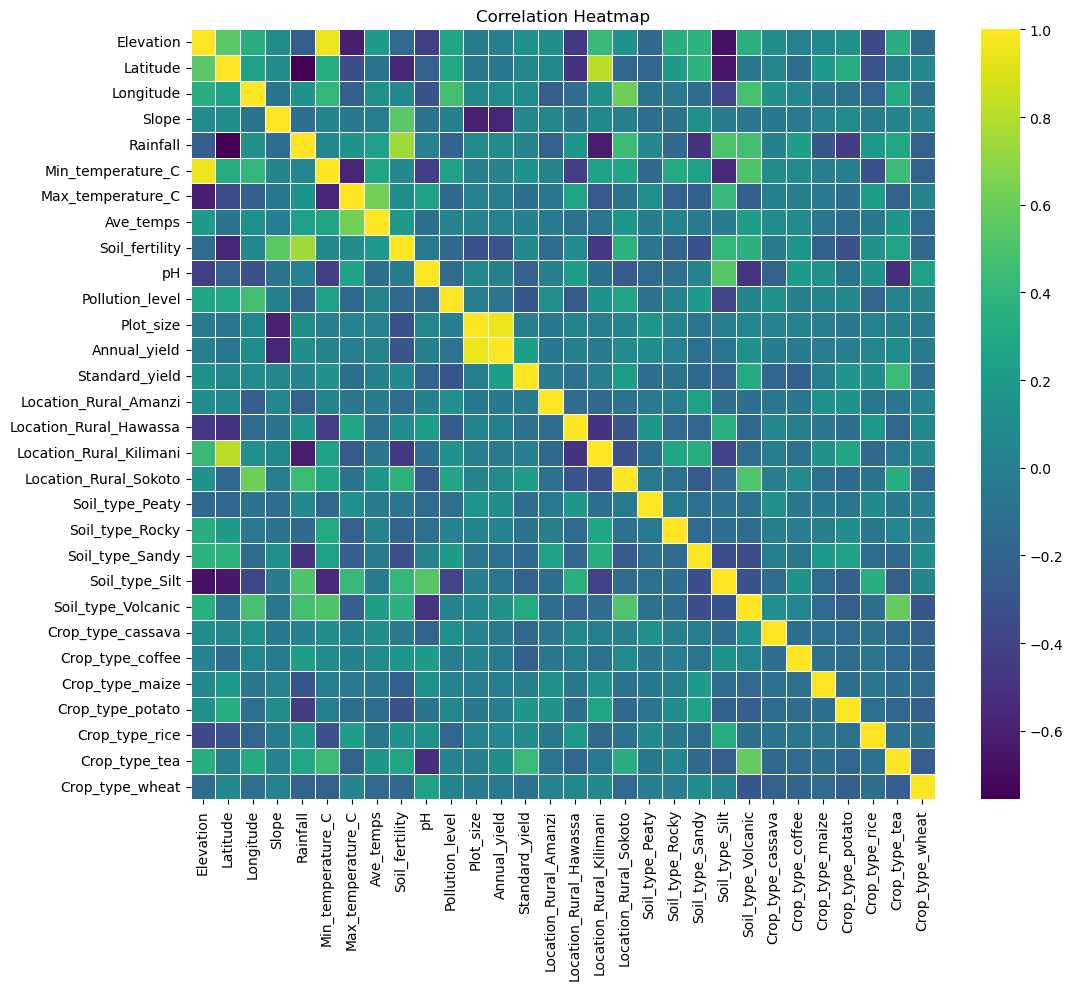

In [24]:
# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), annot=False, cmap='viridis', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")

# Show the plot
plt.show()

### Question 4

In order to fit an ordinary least squares regression model to our encoded data we would need to make sure that all our variables are numeric. Through dummy variable encoding, we converted our categorical variables to multiple int/boolean variables (depending on the environment you are working on). The `sm.OLS()` method itself does not inherently handle boolean data types implicitly.

In most cases, when fitting a model with sm.OLS(), it's essential to ensure that all features are numeric. If boolean columns are present, they should be explicitly converted to numeric types before fitting the model.

Suppose our columns converted to boolean datatypes, which of the following statements is true after converting the boolean columns in the dataset to integer datatype?

* `The boolean columns have been replaced with binary integer representations, with True converted to 1 and False converted to 0.`
* The boolean columns have been removed from the dataset.
* The boolean columns have been replaced with binary integer representations, with True converted to 0 and False converted to 1.
* The boolean columns have been converted to a unique string datatype that is also an integer.

In [26]:
# Convert the categorical boolean values to 0 and 1 for use in regression

# Select boolean columns
bool_col = df_encoded.select_dtypes(include='bool').columns

# Convert all boolean columns to integer
df_encoded[bool_col] = df_encoded[bool_col].astype(int)

df_encoded.head(2)
# The values have been converted successfully!

,Elevation,Latitude,Longitude,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,pH,...,Soil_type_Sandy,Soil_type_Silt,Soil_type_Volcanic,Crop_type_cassava,Crop_type_coffee,Crop_type_maize,Crop_type_potato,Crop_type_rice,Crop_type_tea,Crop_type_wheat
0,786.0558,-7.389911,-7.556202,14.795113,1125.2,-3.1,33.1,15.00,0.62,6.169393,...,1,0,0,1,0,0,0,0,0,0
1,674.3341,-7.736849,-1.051539,11.374611,1450.7,-3.9,30.6,13.35,0.64,5.676648,...,0,0,1,1,0,0,0,0,0,0


### Question 5
Suppose we wish to determine which of the predictors in our dataset are statistically significant. We will follow the following steps:

* Fit a statsmodels regression model to predict `Standard_yield` using our encoded dataset.
* Extract p-values for each predictor from the fitted model to find the ones that are significant based on a given threshold.

Which of the following variables do we find to be statistically significant for predicting `Standard_yield`, based on a p-value threshold of 0.05 `(p-value < 0.05)`?

#### Options

* Slope
* Elevation
* `pH`
* Soil_fertility

In [28]:
# Move 'Standard_yield' to the first column
df_encoded = df_encoded[['Standard_yield'] + [col for col in df_encoded.columns if col != 'Standard_yield']]
print(df_encoded.head(3)) # print to verify the column has been moved

#Generate the regression string
formula_str = df_encoded.columns[0]+' ~ '+'+'.join(df_encoded.columns[1:])
formula_str

   Standard_yield  Elevation  Latitude  Longitude      Slope  Rainfall  \
0        0.577964   786.0558 -7.389911  -7.556202  14.795113    1125.2   
1        0.486302   674.3341 -7.736849  -1.051539  11.374611    1450.7   
2        0.649647   826.5339 -9.926616   0.115156  11.339692    2208.9   

   Min_temperature_C  Max_temperature_C  Ave_temps  Soil_fertility  ...  \
0               -3.1               33.1      15.00            0.62  ...   
1               -3.9               30.6      13.35            0.64  ...   
2               -1.8               28.4      13.30            0.69  ...   

   Soil_type_Sandy  Soil_type_Silt  Soil_type_Volcanic  Crop_type_cassava  \
0                1               0                   0                  1   
1                0               0                   1                  1   
2                0               0                   1                  0   

   Crop_type_coffee  Crop_type_maize  Crop_type_potato  Crop_type_rice  \
0                 0

'Standard_yield ~ Elevation+Latitude+Longitude+Slope+Rainfall+Min_temperature_C+Max_temperature_C+Ave_temps+Soil_fertility+pH+Pollution_level+Plot_size+Annual_yield+Location_Rural_Amanzi+Location_Rural_Hawassa+Location_Rural_Kilimani+Location_Rural_Sokoto+Soil_type_Peaty+Soil_type_Rocky+Soil_type_Sandy+Soil_type_Silt+Soil_type_Volcanic+Crop_type_cassava+Crop_type_coffee+Crop_type_maize+Crop_type_potato+Crop_type_rice+Crop_type_tea+Crop_type_wheat'

In [29]:
#Construct and fit the model using ols
model=smf.ols(formula=formula_str, data=df_encoded)
fitted = model.fit()

In [30]:
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     623.8
Date:                Sat, 14 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:59:59   Log-Likelihood:                 8358.2
No. Observations:                5654   AIC:                        -1.666e+04
Df Residuals:                    5625   BIC:                        -1.647e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [31]:
# Extract p-values 
p_values = fitted.pvalues
p_values

Intercept                   1.428115e-04
Elevation                   5.300993e-01
Latitude                    7.507619e-04
Longitude                   3.686453e-02
Slope                       7.690853e-02
Rainfall                    5.666955e-02
Min_temperature_C           2.032408e-01
Max_temperature_C           1.843501e-01
Ave_temps                   2.113753e-01
Soil_fertility              1.667017e-01
pH                          7.425131e-47
Pollution_level            5.588050e-247
Plot_size                   0.000000e+00
Annual_yield                0.000000e+00
Location_Rural_Amanzi       1.853097e-01
Location_Rural_Hawassa      9.684441e-01
Location_Rural_Kilimani     1.875099e-03
Location_Rural_Sokoto       4.320614e-14
Soil_type_Peaty             1.000074e-61
Soil_type_Rocky             6.256187e-84
Soil_type_Sandy            1.761947e-120
Soil_type_Silt             9.623895e-136
Soil_type_Volcanic          6.050057e-36
Crop_type_cassava           1.131029e-22
Crop_type_coffee

## Challenge 2: Generating a multiple linear regression model

After encoding our variables and performing preliminary analysis, let's continue our efforts to identify the variables that will enable us to construct the most accurate multiple linear regression model possible with the data that we have.

### Question 6
Create a correlation matrix using all the columns in our encoded dataset and display it as a heatmap.<br>

Which of the following independent variables have a strong correlation with one another.

* Plot_size and Crop_type_tea
* Pollution_level and Soil_type_Rocky
* Crop_type_cassava and Soil_type_Sandy
* `Min_temperature_C and Elevation`

In [34]:
# Compute correlations -----> for validation
print(df_encoded['Plot_size'].corr(df_encoded['Crop_type_tea']))
print(df_encoded['Pollution_level'].corr(df_encoded['Soil_type_Rocky']))
print(df_encoded['Crop_type_cassava'].corr(df_encoded['Soil_type_Sandy']))
print(df_encoded['Min_temperature_C'].corr(df_encoded['Elevation']))

9.986874953490453e-05
0.012915216253655515
-0.005827353678890542
0.9564181399438548


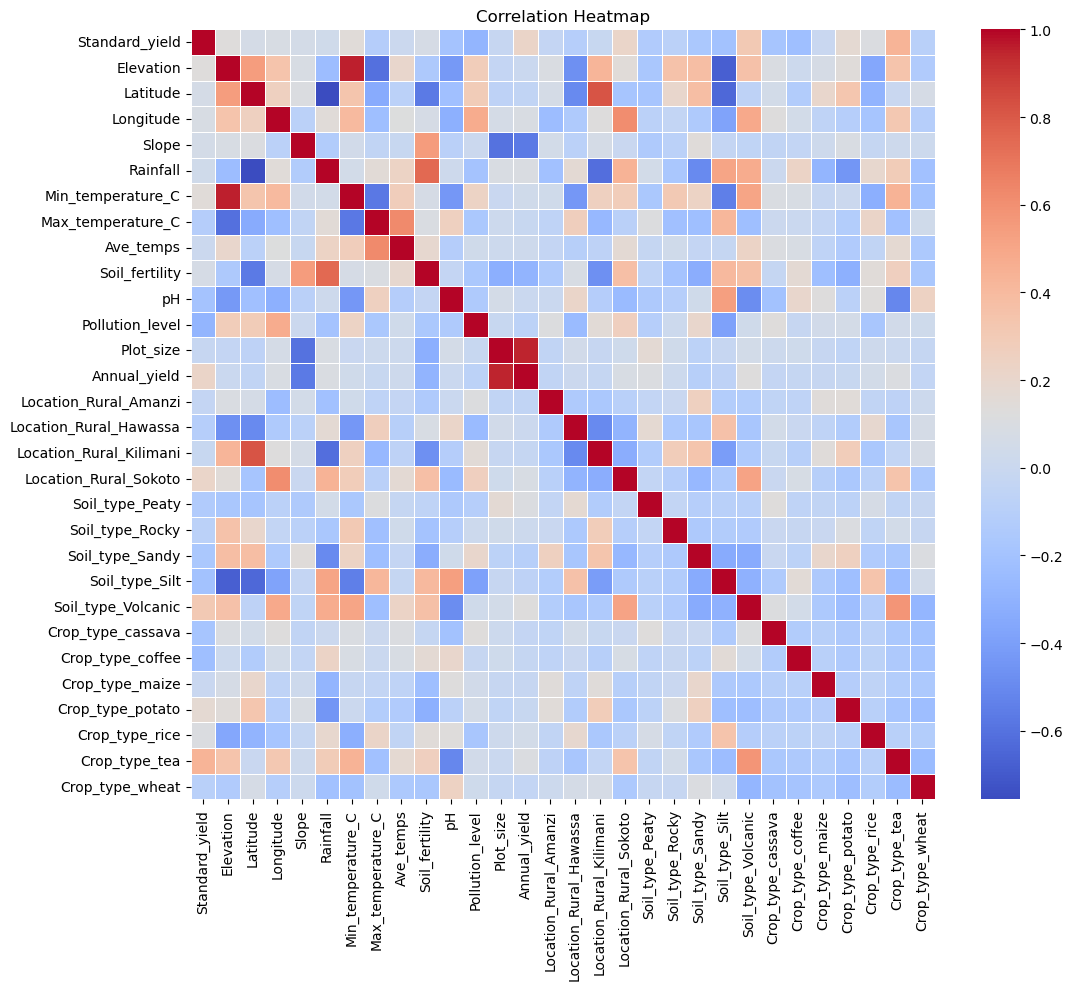

In [35]:
# Compute correlations
corr = df_encoded.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")

# Show the plot
plt.show()

### Question 7
Now that we have analysed our variables, let's fit an ordinary least squares regression model using `statsmodels.formula.api` and then print the model summary. Construct the model using all the independent variables in our encoded dataset (excuding `Field_ID`).<br>

Which of the following statements accurately describes the interpretation of the F-statistic in the context of our regression model?

#### Options
* The F-statistic tests the overall significance of the regression model. A low F-statistic value with a corresponding high p-value  indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* `The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding low p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable`.
* The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding high p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A low F-statistic value with a corresponding low p-value  indicates that the regression model is not statistically significant, meaning that none of the independent variables have a significant effect on the dependent variable.

In [37]:
# The model was run in question 5....Refer to that section 

### Question 8 

This summary  gives us an indication of possible multicollinearity present within our predictor variables. The presence of any correlation among predictors is detrimental to model quality because it tends to increase the standard error of the coefficients and it becomes difficult to estimate the effect of any one predictor variable on the response variable.

To avoid this, let's reduce the number of independent variables included in our model.
Fit the model using the following variables:<br>

* `Pollution_level` 
* `Crop_type_coffee` 
* `Crop_type_tea`
* `Location_Rural_Sokoto`
* `Annual_yield` 
* `Soil_type_Silt`
* `Soil_type_Volcanic`

After reducing the number of dependent variables accordingly, how did the model change?

#### Options:

* `The model worsened`.
* The model improved.
* The model remained unchanged.
* It cannot be determined from the given information.

In [39]:
ols_new_df = df_encoded[['Standard_yield', 'Pollution_level','Crop_type_coffee',
                        'Crop_type_tea','Location_Rural_Sokoto',
                         'Annual_yield','Soil_type_Silt','Soil_type_Volcanic']] 
print(ols_new_df.head(3))

   Standard_yield  Pollution_level  Crop_type_coffee  Crop_type_tea  \
0        0.577964         0.085267                 0              0   
1        0.486302         0.399684                 0              0   
2        0.649647         0.358029                 0              1   

   Location_Rural_Sokoto  Annual_yield  Soil_type_Silt  Soil_type_Volcanic  
0                      0      0.751354               0                   0  
1                      1      1.069865               0                   1  
2                      1      2.208801               0                   1  


In [40]:
# Create OLS formula
ols_formula = ols_new_df.columns[0]+' ~ '+ '+'.join(ols_new_df.columns[1:])
ols_model = smf.ols(formula = ols_formula, data = ols_new_df)
fitted_model = ols_model.fit()
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     552.1
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:00:01   Log-Likelihood:                 5839.8
No. Observations:                5654   AIC:                        -1.166e+04
Df Residuals:                    5646   BIC:                        -1.161e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.56

### Question 9
Let's evaluate our model's results. Generate a scatter plot of the residuals against the fitted values allowing us to visually inspect whether the residuals have constant variance and are distributed randomly around the zero residual line.

What does the scatter plot tell us?

#### Options

* The model has perfect predictive accuracy.
* `The plot indicates homoscedasticity as residuals have a constant variance and are distributed randomly around the zero residual line`.
* There is no linear relationship between the dependent and independent variables.
* The model suffers from multicollinearity.

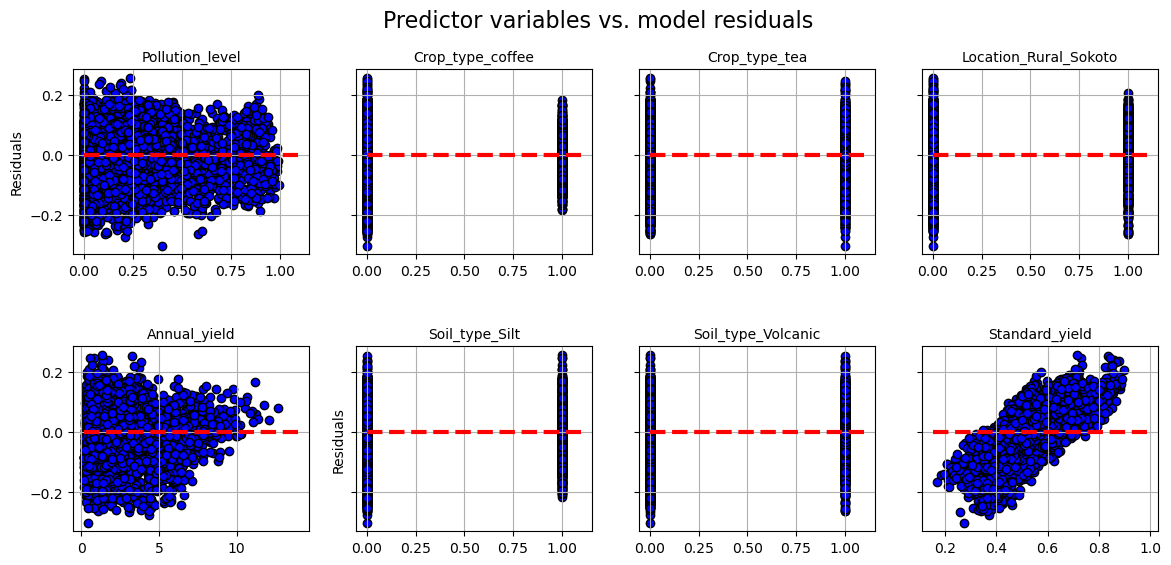

In [42]:
fig, axs = plt.subplots(2,4, figsize=(14,6),sharey=True)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
fig.suptitle('Predictor variables vs. model residuals', fontsize=16)
axs = axs.ravel()

for index, column in enumerate(ols_new_df.columns):
    axs[index-1].set_title("{}".format(column),fontsize=10)
    axs[index-1].scatter(x=ols_new_df[column],y=fitted_model.resid,color='blue',edgecolor='k')
    axs[index-1].grid(True)
    xmin = min(ols_new_df[column])
    xmax = max(ols_new_df[column])
    axs[index-1].hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    if index == 1 or index == 6:
        axs[index-1].set_ylabel('Residuals')

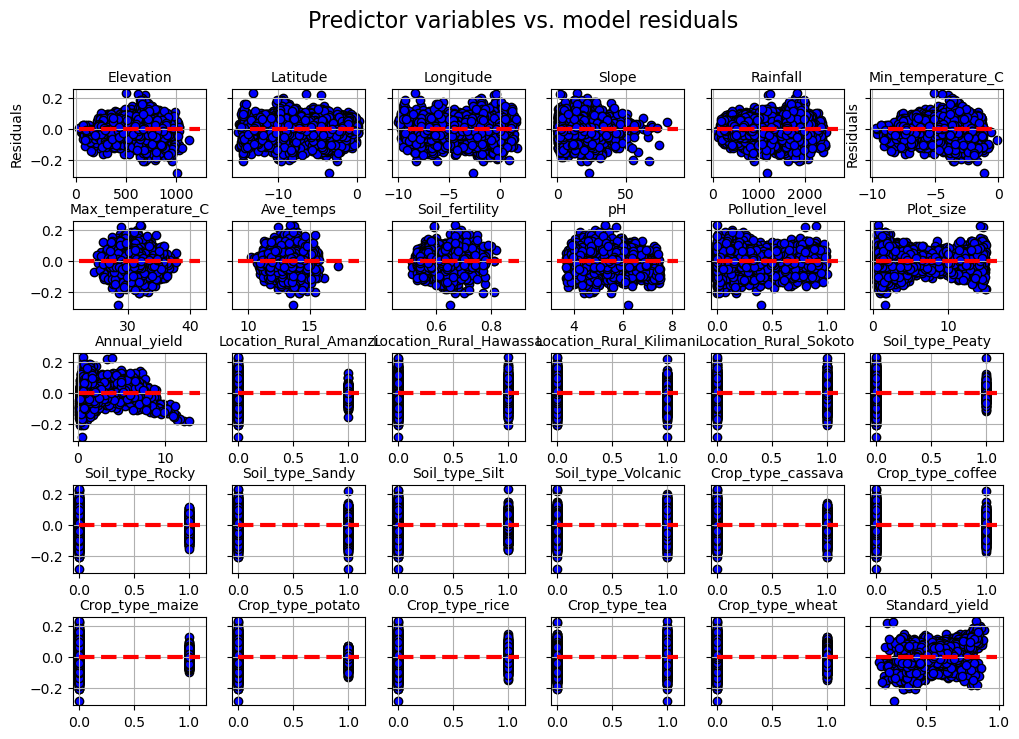

In [43]:
fig, axs = plt.subplots(5,6, figsize=(12,8),sharey=True)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
fig.suptitle('Predictor variables vs. model residuals', fontsize=16)
axs = axs.ravel()

for index, column in enumerate(df_encoded.columns):
    axs[index-1].set_title("{}".format(column),fontsize=10)
    axs[index-1].scatter(x=df_encoded[column],y=fitted.resid,color='blue',edgecolor='k')
    axs[index-1].grid(True)
    xmin = min(df_encoded[column])
    xmax = max(df_encoded[column])
    axs[index-1].hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    if index == 1 or index == 6:
        axs[index-1].set_ylabel('Residuals')

### Question 10
If a linear regression model indicated heteroscedasticity, which of the following actions could be considered to address this issue?

* Applying transformations to the independent variables to better fit the linear relationship.
* Implementing weighted least squares regression to give less emphasis to observations with higher variance in residuals.
* Removing outliers from the dataset to reduce the impact of extreme values on the variance of residuals.
* `All of the above`.

## Challenge 3: Using regularisation to optimise agricultural yield

Continuing with our task, after fitting our model, we decide to go back to the drawing board to explore more ways to implement feature engineering and data pre-processing in order to optimise our model. We suspect that, if we use all the variables available to us, the model might overfit due to the high dimensionality of the data. Regularisation techniques will therefore be critical in building a predictive model that generalises well to new, unseen data.

### Question 11
Our first step in the feature engineering involves creating a new feature, `Temperature_Range`, and scaling features using `StandardScaler`. The difference between `Min_temperature_C` and `Max_temperature_C` is the temperature range.

Given the code block below, which option correctly completes the feature engineering step of creating the `Temperature_Range` column?

**Hint**: Insert the correct code snippet into the appropriate location within the code block to run it.

#### Options:

* `dataset['Temperature_Range'] = dataset[['Min_temperature_C','Max_temperature_C']].min(axis=1)`
* `dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']`---> Answer
* `dataset = dataset.assign(Temperature_Range = dataset['Max_temperature'] - dataset['Min_temperature'])`
* `dataset[['Temperature_Range']] = dataset[['Max_temperature_C']] - dataset[['Min_temperature_C']]`



In [47]:
from sklearn.preprocessing import StandardScaler

# Create a new feature: Temperature Range
df_encoded['Temperature_Range'] = df_encoded['Max_temperature_C'] - df_encoded['Min_temperature_C']

# Select features for scaling (exclude non-numeric or target variables)
features = ['Elevation', 'Slope', 'Rainfall', 'Ave_temps', 'Temperature_Range', 'Soil_fertility', 'pH', 'Pollution_level']

# Initialise StandardScaler and apply it to the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_encoded[features])

# Show the first 5 rows of the scaled features
print(scaled_features[:5])

[[ 0.85426539  0.31997088 -0.15356676  2.21747303  0.30626766  0.01544079
   0.71256827 -0.61634976]
 [ 0.21055364 -0.03858151  0.49777372  0.15900087 -0.25298298  0.4619994
   0.08816394  0.7886906 ]
 [ 1.08748981 -0.04224188  2.01496684  0.09662293 -1.66755812  1.57839593
  -0.34858051  0.60254524]
 [-0.3620941  -0.4856324  -1.74719984 -0.02813296  0.8984154  -1.77079366
  -0.35345077  0.28374058]
 [ 1.43215211  4.53523034 -0.83392242  1.28180387 -0.58195394  2.24823384
   0.14466333 -0.80437805]]


C:\Users\abc\AppData\Local\Temp\ipykernel_18420\4197974243.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['Temperature_Range'] = df_encoded['Max_temperature_C'] - df_encoded['Min_temperature_C']


### Question 12


Consider a scenario where we decide to employ LASSO regression to identify predictive features associated with our dependent variable.

We implement the Python code block provided below.

What is the purpose of the `LassoCV(cv=5)` constructor parameter `cv=5`?

#### Options:

* `It indicates that 5-fold cross-validation should be used to select the best regularisation parameter`.
* It sets the penalty coefficient to 5, increasing the regularisation strength.
* It specifies that the LASSO model should use a 5-degree polynomial feature expansion.
* It defines that the model should only select 5 features at most.

In [49]:
from sklearn.linear_model import LassoCV

# scaled_features is our matrix of scaled features and dataset['Standard_yield'] is the target variable
lasso = LassoCV(cv=5).fit(scaled_features, df_encoded['Standard_yield'])

# Find the features with non-zero coefficients
selected_features = [features[i] for i, coef in enumerate(lasso.coef_) if coef != 0]
selected_features

['Elevation',
 'Slope',
 'Rainfall',
 'Ave_temps',
 'Temperature_Range',
 'pH',
 'Pollution_level']

### Question 13

In trying to address multicollinearity in our dataset, we also decide to implement Ridge regression. After understanding that Ridge regression applies an L2 penalty to the coefficients to reduce their magnitude without setting them to zero, we decide to use `RidgeCV` for applying Ridge regression with cross-validation to select the optimal penalty strength. Given the snippet of code below, which parameter correctly adjusts the strength of the regularisation applied to the model?

**Hint**: Insert the correct code snippet into the appropriate location within the code block to run it.

#### Options:
* `cv=[0.001, 0.01, 0.1, 1, 10, 100]`
* `fit_intercept=True`
* `alphas=[0.001, 0.01, 0.1, 1, 10, 100]`------> corrects strength of the regularization
* `scoring='neg_mean_squared_error`

In [51]:
from sklearn.linear_model import RidgeCV

alphas = [0.001, 0.01, 0.1, 1, 10, 100] # Regularization parameter (L2)
X = scaled_features # Independent variables
y = df_encoded['Standard_yield'] # dependent varaibale

# Apply Ridge regression with cross-validation
ridge = RidgeCV(alphas=alphas, cv=5).fit(X, y)

In [52]:
print(f' The best parameter is: {(ridge.best_score_)}')
print(f'The coeficient for the model: {(ridge.coef_[0])}')
print(F' The y_itercept for the model: {(ridge.intercept_)}')

 The best parameter is: 0.1513599270096531
The coeficient for the model: 0.00849134157322456
 The y_itercept for the model: 0.5344051174973649


### Question 14

Given our dataset includes variables such as `Elevation` and `Slope`, and considering the potential interactions between these variables might impact crop yield, we aim to capture both these interactions and possible non-linear relationships. Which of the following methods is specifically designed to create a quadratic interaction term without including an intercept in the feature set?

**HINT:** Consider utilising `sklearn`'s feature transformation tools for this purpose.

* `poly = PolynomialFeatures(degree=2, include_bias=False)` -------> Answer
* `poly = PolynomialFeatures(degree=1, include_bias=False)` 
* `poly = PolynomialFeatures(degree=3, include_bias=True)` 
* `poly = PolynomialFeatures(degree=2, include_bias=True)`

In [54]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)

poly_features = poly.fit_transform(df_encoded[['Elevation', 'Slope']])

# Display the shape of the new feature matrix
poly_features.shape

(5654, 5)

### Question 15

After implementing Ridge regression to address multicollinearity and prevent overfitting in our model we need to interpret the coefficients to understand the impact of each feature on the standard yield.

Based on the output of the Ridge regression coefficients in the code block below, which statement is true regarding the impact of each feature on the standard yield?

#### Options:

* Feature 1 has the highest positive impact, followed by Feature 2 and Feature 3.
* Feature 3 has the highest positive impact, followed by Feature 1 and Feature 2.
* The coefficients are inconclusive; further analysis is needed to determine the impact of each feature.
* `Feature 2 has the highest positive impact, while Feature 3 and Feature 1 have negative impacts`.

In [56]:
from sklearn.linear_model import Ridge
import numpy as np

# Assuming `X` is the feature matrix and `y` is the target variable
X = np.array([[0.5, 0.2, 0.1],
              [0.9, 0.3, 0.5],
              [0.3, 0.8, 0.2]])
y = np.array([0.7, 0.6, 0.8])

# Fit Ridge regression model with alpha = 0.1
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X, y)

# Display the coefficients of the model
ridge_model.coef_


array([-0.13661379,  0.10262221, -0.07348657])

## Challenge 4: Making a prediction using decision trees

After learning that decision trees are easy to implement and are capable of handling both categorical and numerical data while being resilient to outliers, we decide to implement a decision tree on our encoded dataset.

### Question 16
Train a decision tree with the following specifications:
* Using our **previously encoded dataset**, split the data into dependent and independent variables using all the features except for `Standard_yield` and `Field_ID` as independent variables.
* Split the data into training and testing data.
* Use the `DecisionTreeRegressor` to fit a model using a `max_depth' of 2 and a `random_state` of 42.

Using the trained Decision Tree Regressor model, make a prediction for `y` given the following x-values:<br> 
`[864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, -3.4100000000000006, 36.410000000000004,`
`16.5,0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 0.8264890400277934,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0, 0.0,0.0,0.0,0.0,0.0]`

What is the value of the predicted y?

#### Options
* 0.3250077
* 0.6654377
* `0.48494414`
* 0.8050340

In [59]:
# Import libaries
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

y = df_encoded['Standard_yield']
X = df_encoded.drop('Standard_yield', axis = 1)

# Reshape X
X = X.to_numpy()

# Split the data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the Decision Tree Regressor
model = DecisionTreeRegressor(max_depth = 2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# use the model to predict y given the x_values
x_values = [864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, 
            -3.4100000000000006, 36.410000000000004, 16.5,0.682, 6.7863323423108195, 0.09379352739936421,
            1.4300000000000002, 0.8264890400277934,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0,
            0.0,0.0,0.0,0.0,0.0, 0.0]
# Convert to numpy array
x_values = np.array(x_values).reshape(1,-1)

# Make predictions
y_pred = model.predict(x_values)
print(f' The predicted values for y is: {y_pred}')

 The predicted values for y is: [0.48494414]


In [60]:
x_values

array([[ 8.64661380e+02, -8.12890219e+00, -8.31182272e+00,
         1.62746243e+01,  1.23772000e+03, -3.41000000e+00,
         3.64100000e+01,  1.65000000e+01,  6.82000000e-01,
         6.78633234e+00,  9.37935274e-02,  1.43000000e+00,
         8.26489040e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.10000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.10000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

### Question 17

Based on the model above, what is the value of our RMSE?

* 0.0658
* `0.0881`
* 0.5656
* 0.8810

In [62]:
# predict the test set
pred_y_test = model.predict(X_test)

# Get the RMSE based on the predicted and observed y values
RMSE = metrics.root_mean_squared_error(pred_y_test,y_test)

# print RMSE
print(f'The RMSE for the model is: {round(RMSE,4)}')


The RMSE for the model is: 0.0881


### Question 18
Which of the following statements is correct about our RMSE?

#### Options
* `An RMSE of 0.0881 suggests that, on average, the predicted values are off by approximately 0.0881 units`
* An RMSE value of 0.0881 suggests that, at most, the predicted values deviate by approximately 0.08 units from the actual values.
* An RMSE of 0.0881 indicates a perfect fit of the model to the training data.
* An RMSE of 0.0881 suggests that the predicted values are correct 8.81% of the time.

### Question 19 
What is the likely effect of adjusting the `max_depth` parameter in a Decision Tree model?

#### Options

* Lower max_depth values may lead to increased model complexity and a higher risk of underfitting
* Higher max_depth values may lead to decreased model complexity and a lower risk of overfitting
* Higher max_depth values reduce the likelihood of capturing complex relationships in the data.
* `Higher max_depth values may lead to increased model complexity and a higher risk of overfitting`.


### Question 20 
Let's attempt to enhance our model's performance by setting the `max_depth` hyperparameter to 5.

True or false? The decision tree model was improved by fitting it with a `max_depth` parameter of 5.

#### Options
* `True`
* False

In [66]:
# Instantiate the Decision Tree Regressor with a depth of 5
model_2 = DecisionTreeRegressor(max_depth = 5, random_state=42)

# Fit the model
model_2.fit(X_train, y_train)

# Predict the test set
pred_y_test_2 = model_2.predict(X_test)

# Get the RMSE based on the predicted and observed y values
RMSE_2 = metrics.root_mean_squared_error(pred_y_test_2,y_test)

# print RMSE
print(f'The RMSE for the model is: {round(RMSE_2,4)}')

The RMSE for the model is: 0.0633


## Challenge 5: Ensemble Methods & Bootstrapping

Using our original dataset, our objective is to explore ensemble methods and bootstrapping techniques to enhance the model performance. We'll work with a subset of features from the dataset to predict the `Standard_yield`.

### Question 21 
Consider the following approach to implement a bootstrap aggregation (bagging) for predicting the `Standard_yield` based on features `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`. Given are the steps and part of the Python code implementing this method. Our task is to identify the correct piece of code that completes the implementation.

The steps for the implementation are as follows:

1. Create an empty list named `predictions` to store predictions from each bootstrap sample.
2. Generate `n_bootstrap_samples` bootstrap samples from the original dataset.
3. For each bootstrap sample, fit a linear regression model and predict the `Standard_yield` on the entire dataset.
4. Store each set of predictions in the predictions list.
5. Average the predictions across all bootstrap samples to obtain the final bagged prediction.
6. Compute and print the mean squared error (MSE) to evaluate the performance of the bagged model.


Below is the code block with a missing part that needs to be completed:

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import numpy as np

# X_train, y_train represent the features and target variable from the training data
X = df[['Elevation', 'Slope', 'Soil_fertility', 'Pollution_level']]
y = df['Standard_yield']

predictions = []
n_bootstrap_samples = 100

for _ in range(n_bootstrap_samples):
    X_sample, y_sample = resample(X, y)
    model = LinearRegression()
    model.fit(X_sample, y_sample)
    y_pred = model.predict(X)
    predictions.append(y_pred)
    
    # Average the predictions
    bagged_prediction = np.mean(predictions, axis=0)
    
    # Calculate the MSE 
    mse_bagged = mean_squared_error(y, bagged_prediction)

print(f"Mean Squared Error of Bagged Linear Regression Models: {mse_bagged}")


Mean Squared Error of Bagged Linear Regression Models: 0.01084047713236787


Which code should replace the # MISSING PART HERE section to correctly implement the averaging of predictions and computation of the mean squared error?

#### Options


* `bagged_prediction = np.average(predictions, axis=1)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.median(predictions, axis=0)`

  `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.mean(predictions, axis=0)`------> Answer

   `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.mean(predictions, axis=1)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)` 

### Question 22 

Given the following code snippet that applies a `RandomForestRegressor` to a dataset, which parameter in the `RandomForestRegressor` constructor is crucial for implementing the random subspace method by allowing the algorithm to select a random subset of features for each split?

#### Options
* `max_depth`
* `random_state`
* `max_features`-----------> `Answer`
* `n_estimators`

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialise and train the random forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)

# Predict using the random forest model
y_pred_rf = rf_model.predict(X)

# Evaluate the model
mse_rf = mean_squared_error(y, y_pred_rf)
print(f"Mean Squared Error of Random Forest Regressor: {mse_rf}")


Mean Squared Error of Random Forest Regressor: 0.0010948637582531549


### Question 23

### Question 23 (Medium)

Consider the theoretical setup for a stacking ensemble model designed for a regression task. The first layer of this model includes three different types of regression models: linear regression, ridge regression, and a support vector machine (SVM) with a linear kernel. The second layer, or the final estimator, uses a linear regression model to combine the predictions from the first layer. The goal is to theoretically predict `Standard_yield` based on features such as `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`, with the intention to evaluate the model's hypothetical performance using the Mean Squared Error (MSE).

Given the following theoretical code snippet that outlines this stacking ensemble model's setup, what should replace the `_____` in the code to correctly configure the SVM with a linear kernel as part of the base learners in the stacking model?

#### Options
* `linear`-------------> Answer
* `lin`
* `sigmoid`
* `degree=1`

In [74]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error

# Define base learners
estimators = [
    ('lr', LinearRegression()),
    ('ridge', Ridge()),
    ('svr', SVR(kernel='linear'))
]

# Define the theoretical stacking model
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# Note: Assume X, y represent the features and target variable respectively, for a theoretical prediction scenario.

### Question 24

Consider the following Python code snippet that aims to implement a 5-fold cross-validation scheme to estimate the accuracy of a ridge regression model. This model uses bootstrapped samples within each fold to predict `Standard_yield` and calculates the average Mean Squared Error (MSE) across all folds.

Which of the following options correctly fill in the blanks to ensure the code correctly implements the described functionality?

#### Options
* `scoring='r2'`, `cv=10`
* `scoring='mean_absolute_error'`, `cv=5`
* `scoring='neg_mean_squared_error'`, `cv=5`----------------> Answer
* `scoring='neg_mean_squared_error'`, `cv='Bootstrap'`


In [76]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialise the ridge regression model
ridge_model = Ridge()

# Perform 5-fold cross-validation with bootstrapping
scores = cross_val_score(ridge_model, X, y, scoring='neg_mean_squared_error', cv=5) #add correct option here 

# Convert scores to positive MSE
mse_scores = -scores

# Calculate average MSE
average_mse = np.mean(mse_scores)
print(f"Average Mean Squared Error from Cross-Validation: {average_mse}")

Average Mean Squared Error from Cross-Validation: 0.010875483717316465


### Question 25

Consider the code snippet that extracts and prints the feature importances from a trained random forest regressor model. The model is used to predict `Standard_yield` based on various features. The code utilises the `feature_importances_` attribute of the random forest model to obtain importance scores for each feature.

Which of the following statements best describes the purpose and outcome of the provided code snippet?

#### Options

* `The code identifies and prints the importance scores for each feature in the random forest model, indicating how much each feature contributes to the model's ability to predict `Standard_yield`. Higher scores suggest a greater contribution to the prediction.`

* The code counts the number of times each feature is used to split the data across all trees in the random forest, thereby determining each feature's importance in predicting `Standard_yield`.

* The code calculates and prints the coefficient values for each feature used in the  random forest, model to predict `Standard_yield`, indicating the strength and direction of the relationship between each feature and the target variable.

* The code computes the correlation between each feature and the target variable `Standard_yield`, printing a list of features sorted by their correlation coefficients to identify the most relevant predictors.

In [78]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Elevation, Importance: 0.3200870554543833
Feature: Slope, Importance: 0.22047615756224123
Feature: Soil_fertility, Importance: 0.1524271647331845
Feature: Pollution_level, Importance: 0.30700962225019085


## Challenge 6: Random forests
In this challenge, we want to test how our data fits to a random forest model and other functionalities that come with its such as analysing feature importance.

We are required to write a function named `train_rf_model` that trains and tests a random forest model on a given dataset. Our function should do the following:

* Take a `RandomForestRegressor` object (with any desired hyperparameters set) as input,
* Separate the features `X` and target `y` dataframes
* Split the data into training and testing sets - use a test size of `20%` and a random state of `42` for reproducibility
* Fit the model to the training data
* Make predictions on the testing set
* Return the trained model, the R-squared score, and the Mean Squared Error (MSE) of the test set predictions.

In [80]:

# Get the dependent (y) and X variables
y = df_encoded['Standard_yield']
X = df_encoded.drop('Standard_yield', axis = 1)

X = X.to_numpy()
# Split the data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

# Instantiate the Random Forest Model
rf_model =RandomForestRegressor(random_state=42, max_depth=15, n_estimators=100)


# Fit the model
rf_model.fit(X_train, y_train)

# Predict the test set
y_rf_pred = rf_model.predict(X_test)

In [81]:
print(f"Shape of y_rf_pred: {y_rf_pred.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of y_rf_pred: (1131,)
Shape of y_test: (1131,)


In [82]:
R2 = metrics.r2_score(y_rf_pred, y_test)
MSE = metrics.mean_squared_error(y_rf_pred,y_test)

print(f'The R squared value for the Random Forest model on the test set is: {round(R2,4)},\n and the MSE is {round(MSE,4)}')

The R squared value for the Random Forest model on the test set is: 0.9534,
 and the MSE is 0.0006


### Question 26
1) Implement the function outlined above.

2) Using the function, train a random forest model on our dataset with random_state set to 42, and max_depth=15, while leaving all other hyperparameters at their defaults. Use all the features available in the encoded dataset for this task. What are the R-squared and MSE scores for the model on the test data?

#### Options

* R2: 0.0059, MSE: 0.6198
* R2: 0.5555, MSE: 0.2345
* `R2: 0.9586, MSE: 0.0006`
* R2: 0.8196, MSE: 0.0500

### Question 27

We want to examine how our data will fit to a random forest model when we tune the number of trees. We want to train and compare two random forest models with the same dataset as in the previous exercise. The first model should be trained with `150` trees, and the second model with `200` trees. Both models should use the default hyperparameters for all other settings, apart from a random_state of `42` to ensure reproducibility. After evaluating both models on the test set, how does the error differ between the two models?

#### Options

* The error increased when the number of trees was increased from 150 to 200.
* The model with 200 trees showed a significant decrease in error compared to the model with 150 trees.
* The model with 200 trees showed a very slight decrease in error compared to the model with 150 trees.
* `There was no change in the error`.

In [85]:
# Model 1 with 150 trees

# Get the dependent (y) and X variables
y = df_encoded['Standard_yield']
X = df_encoded.drop('Standard_yield', axis = 1)

X = X.to_numpy()
# Split the data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

# Instantiate the Random Forest Model
rf_model_2 =RandomForestRegressor(random_state=42, max_depth=15, n_estimators=150)


# Fit the model
rf_model_2.fit(X_train, y_train)

# Predict the test set
y_rf_pred = rf_model_2.predict(X_test)

R2 = metrics.r2_score(y_rf_pred, y_test)
MSE = metrics.mean_squared_error(y_rf_pred,y_test)

print(f'The R squared value for the Random Forest model on the test set is: {round(R2,6)},\n and the MSE is {round(MSE,6)}')

The R squared value for the Random Forest model on the test set is: 0.953768,
 and the MSE is 0.00055


In [86]:
# Model 2 with 200 trees

# Get the dependent (y) and X variables
y = df_encoded['Standard_yield']
X = df_encoded.drop('Standard_yield', axis = 1)


# Split the data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

# Instantiate the Random Forest Model
rf_model_3 =RandomForestRegressor(random_state=42, max_depth=15, n_estimators=200)


# Fit the model
rf_model_3.fit(X_train, y_train)

# Predict the test set
y_rf_pred = rf_model_3.predict(X_test)

R2 = metrics.r2_score(y_rf_pred, y_test)
MSE = metrics.mean_squared_error(y_rf_pred,y_test)

print(f'The R squared value for the Random Forest model on the test set is: {round(R2,6)},\n and the MSE is {round(MSE,6)}')

The R squared value for the Random Forest model on the test set is: 0.953782,
 and the MSE is 0.00055


### Question 28
Which of the following is a possible effect of increasing the number of trees in a random forest regression model?

#### Options
* `Increasing the number of trees increases the model’s predictive ability up to a certain point, after which additional trees do not significantly impact performance`.
* Increasing the number of trees always improves the model's predictive ability
* Increasing the number of trees significantly decreases the model's predictive ability
* The number of trees in a random forest model has no impact on the model's predictive ability.

### Question 29

Following the training of our random forest models, we decide to analyse the feature importance scores provided by the model built using 200 trees. Our aim is to identify which features the model considers most significant in predicting the target variable.

Which of the following does the model consider to be the top 3 most significant features in predicting Standard_yield?

#### Options

* Soil_fertility, Rainfall, Slope
* `Rainfall, Crop_type_tea, Latitude`
* pH, Rainfall, Location_Rural_Hawassa
* Elevation, Soil_fertility, pH

In [89]:
# Extract feature importances
feature_importances = rf_model_3.feature_importances_

# Print feature importances with corresponding feature names
for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Elevation, Importance: 0.07715453574241274
Feature: Latitude, Importance: 0.15510273029097868
Feature: Longitude, Importance: 0.009189184569769025
Feature: Slope, Importance: 0.002708118825210158
Feature: Rainfall, Importance: 0.20408550371915118
Feature: Min_temperature_C, Importance: 0.017405009041726247
Feature: Max_temperature_C, Importance: 0.0017309739200803307
Feature: Ave_temps, Importance: 0.0024422287088034086
Feature: Soil_fertility, Importance: 0.0016634600229276952
Feature: pH, Importance: 0.11965080471960193
Feature: Pollution_level, Importance: 0.0628867611126551
Feature: Plot_size, Importance: 0.002633248973998309
Feature: Annual_yield, Importance: 0.004829056170820976
Feature: Location_Rural_Amanzi, Importance: 3.876670345094418e-05
Feature: Location_Rural_Hawassa, Importance: 0.000217407749490537
Feature: Location_Rural_Kilimani, Importance: 0.00013852889029835325
Feature: Location_Rural_Sokoto, Importance: 0.00024363715939196794
Feature: Soil_type_Peaty, Imp

In [90]:
# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model_3.feature_importances_
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print sorted DataFrame
print(importance_df)   

                    Feature  Importance
4                  Rainfall    0.204086
27            Crop_type_tea    0.185083
1                  Latitude    0.155103
9                        pH    0.119651
0                 Elevation    0.077155
10          Pollution_level    0.062887
26           Crop_type_rice    0.040989
23         Crop_type_coffee    0.040209
25         Crop_type_potato    0.026260
28          Crop_type_wheat    0.022205
5         Min_temperature_C    0.017405
2                 Longitude    0.009189
22        Crop_type_cassava    0.007665
12             Annual_yield    0.004829
19          Soil_type_Sandy    0.004393
21       Soil_type_Volcanic    0.004103
29        Temperature_Range    0.003111
3                     Slope    0.002708
11                Plot_size    0.002633
7                 Ave_temps    0.002442
24          Crop_type_maize    0.001804
6         Max_temperature_C    0.001731
8            Soil_fertility    0.001663
20           Soil_type_Silt    0.000965


### Question 30
Which of the following initialised random forest models will allow access and calculation of the Out-of-Bag (OOB) score for performance evaluation without requiring a separate validation set?

#### Options
* RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)
* `RandomForestRegressor(n_estimators=150, max_depth=None, oob_score=True)`
* RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_leaf=4, oob_score=False)
* RandomForestRegressor(n_estimators=120, max_features='sqrt', min_samples_leaf=2)

## Challenge 7: Governance and ethics

In this challenge, we will delve into the principles of governance and ethics within data science. We will explore the critical aspects of accountable governance, the importance of ethical guidelines, and the role of participatory governance in fostering an inclusive decision-making environment.

### Question 31

What is the most important aspect of accountable governance?  

#### Options
- `Defining roles and responsibilities clearly`  
- Avoiding regulatory compliance  
- Minimising data quality  
- Disregarding industry standards  


### Question 32

True or false: Responsive governance is rigid and does not adapt to new challenges.

#### Options 
- `False`  
- True  

### Question 33 

Which of the following best describes the purpose of ethical guidelines in data governance?  

#### Options
- `To provide standards for behaviour and practices` 
- To mandate data deletion  
- To increase data redundancy  
- To prohibit data collection 

### Question 34 
True or false: Participatory governance excludes input from non-management employees.

#### Options
- `False`  
- True  

### Question 35
True or false: Governance frameworks do not need to be regularly updated.

#### Options
- `False`  
- True  

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>